In [1]:
import os
import pickle

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from jax import random
from scipy import stats, integrate
from numpyro.diagnostics import hpdi

from hbmep.model import BaseModel
from hbmep import functional as F
from hbmep.util import site

from hbmep.notebooks.rat.util import annotate_heatmap

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
ignore_warnings = np.errstate(divide='ignore',invalid='ignore')

HOME = os.getenv("HOME")
EXPERIMENT = "lshie" # lcirc, csmalar

MODEL_DIR = f"{HOME}/reports/hbmep/notebooks/rat/lognhb/nhb__4000w_1000s_4c_1t_20d_95a_tm/{EXPERIMENT}/rectified_logistic"
INFERENCE_FILE = os.path.join(MODEL_DIR, "inference.pkl")
MODEL_FILE = os.path.join(MODEL_DIR, "model.pkl")
EXPERIMENT_TOML_MAP = {"lcirc": "L_CIRC", "lshie": "L_SHIE", "csmalar": "C_SMA_LAR"}
TOML_PATH = f"{HOME}/repos/rat-mapping-paper/configs/{EXPERIMENT_TOML_MAP[EXPERIMENT]}.toml"

MAX_INTENSITY = 9 # 2 ** 9 = 512
NUM_POINTS = 200 # reduce if ram overflows


/home/vishu/repos/refactor/hbmep/.venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
src = INFERENCE_FILE
with open(src, "rb") as f: df, encoder, posterior, _ = pickle.load(f)

src = MODEL_FILE
with open(src, "rb") as f: model, = pickle.load(f)

subjects = sorted(df['participant'].unique())
subjects_inverse = encoder['participant'].inverse_transform(subjects).tolist()
subjects_inverse

positions = sorted(df['compound_position'].unique())
positions_inverse = encoder['compound_position'].inverse_transform(positions).tolist()
positions_inverse

charges = sorted(df["compound_charge_params"].unique())     # Sort the encoded charges so they are in the same order as the posterior samples
charges_inverse = encoder['compound_charge_params'].inverse_transform(charges).tolist()     # Then decode the charges, this maintains the order of the charges
charges_inverse

max_intensity_df = df.groupby(by=model.features, as_index=False).agg({model.intensity: np.max})
keys = max_intensity_df[model.features].apply(tuple, axis=1).values.tolist()
values = max_intensity_df[model.intensity].values.tolist()
max_intensity_map = dict(zip(keys, values))

num_features = df[model.features].to_numpy().max(axis=0) + 1
max_intensity = np.full(num_features, np.nan)
for u, v in max_intensity_map.items(): max_intensity[*u] = v
max_intensity.shape

max_intensity = max_intensity.reshape(max_intensity.shape[0], -1)
max_intensity.shape

labels = []
for pos in positions_inverse:
    for charge in charges_inverse:
        labels.append(f"{pos}__{charge[:2]}")


['amap01',
 'amap02',
 'amap03',
 'amap04',
 'amap05',
 'amap06',
 'amap07',
 'amap08']

['-C6LC', 'C6LC-', 'C6LC-C6LX', 'C6LX-C6LC']

['20-0-80-25', '50-0-50-100']

(8, 4, 2)

(8, 8)

In [3]:
a = posterior[site.a]
a.shape


(4000, 8, 4, 2, 6)

In [4]:
named_params = [site.a, site.b, site.g, site.h, site.v]
params = {
    u: v.reshape(*v.shape[:-3], -1, v.shape[-1])
    for u, v in posterior.items()
    if u in named_params
}
params[site.a].shape

params = {u: v[None, ...] for u, v in params.items()}
params[site.a].shape


(4000, 8, 8, 6)

(1, 4000, 8, 8, 6)

In [5]:
x = np.linspace(0, MAX_INTENSITY, NUM_POINTS)
x.shape

x_broad = x[:, *(None for _ in range(params[site.a].ndim - 1))]
x_broad.shape


(200,)

(200, 1, 1, 1, 1)

In [6]:
# Response
y = np.array(F.rectified_logistic(x_broad, **params))
y.shape

y = np.nanmean(y, axis=1, keepdims=True)
y.shape


An NVIDIA GPU may be present on this machine, but a CUDA-enabled jaxlib is not installed. Falling back to cpu.


(200, 4000, 8, 8, 6)

(200, 1, 8, 8, 6)

In [7]:
max_intensity_broad = max_intensity[None, None, ..., None]
max_intensity_broad.shape


(1, 1, 8, 8, 1)

In [8]:
y_at_max_intensity = np.array(F.rectified_logistic(
    max_intensity_broad, **params
))
y_at_max_intensity.shape

y_at_max_intensity = np.nanmean(y_at_max_intensity, axis=1, keepdims=True)
y_at_max_intensity.shape


(1, 4000, 8, 8, 6)

(1, 1, 8, 8, 6)

In [9]:
# Get max
y_max = np.nanmax(y_at_max_intensity, axis=3, keepdims=True)
y_max.shape


(1, 1, 8, 1, 6)

In [10]:
# Normalize
with ignore_warnings:
    y_norm = np.where(y_max, y / y_max, 0.)
    y = y_norm.copy()
    y.shape


(200, 1, 8, 8, 6)

In [11]:
# Calculate selectivity
p = np.nansum(y, axis=-1, keepdims=True)
p.shape

with ignore_warnings:
    p = np.where(p, y / p, 1 / y.shape[-1])
    p.shape

with ignore_warnings:
    plogp = np.where(p, p * np.log(p), 0)
    plogp.shape

entropy = 1 + (plogp.sum(axis=-1) / np.log(y.shape[-1]))
entropy.shape

np.isnan(entropy).sum()
auc = np.trapz(y=entropy, x=x, axis=0)
auc.shape


(200, 1, 8, 8, 1)

(200, 1, 8, 8, 6)

(200, 1, 8, 8, 6)

(200, 1, 8, 8)

0

(1, 8, 8)

In [12]:
cum_auc = integrate.cumulative_trapezoid(y=entropy, x=x, axis=0)
cum_auc.shape


(199, 1, 8, 8)

In [13]:
# Transpose trick to get pairwise diffs
arr = cum_auc.copy()
diff = arr[..., None] - arr[..., None, :]
diff.shape


(199, 1, 8, 8, 8)

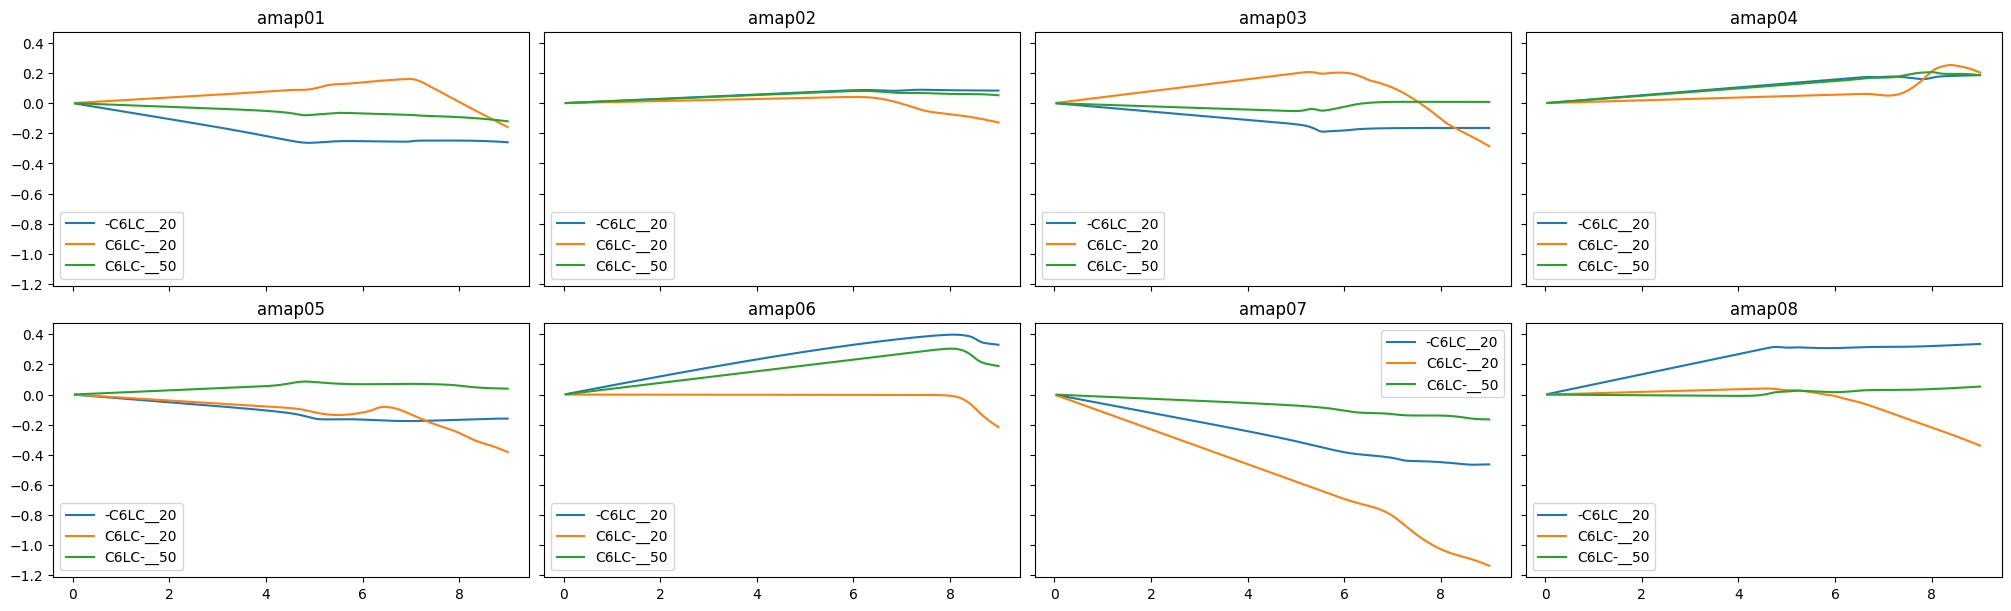

In [14]:
reference = 1
diff_from_reference = diff[..., reference, :]
diff_from_reference.shape

# diff_from_reference_hdi = hpdi(diff_from_reference, prob=.95, axis=1)
# diff_from_reference_hdi.shape

subset = range(4, 8)
subset = range(0, 4)

nr, nc = 2, 4
fig, axes = plt.subplots(
    nr, nc, figsize=(5 * nc, 3 * nr), constrained_layout=True, squeeze=False, sharex=True, sharey=True
)
counter = 0
for subject_idx, subject in enumerate(subjects_inverse):
    ax = axes[counter // nc, counter % nc]

    for label_idx in subset:
        label = labels[label_idx]
        if label_idx == reference: continue
        curr_diff = diff_from_reference[...,  subject_idx, label_idx]
        # curr_diff_hdi = diff_from_reference_hdi[..., subject_idx, label_idx]
        # ax.fill_between(x[1:], curr_diff_hdi[:, 0], curr_diff_hdi[:, 1], alpha=.4)
        sns.lineplot(x=x[1:], y=np.nanmean(curr_diff, axis=-1), label=label, ax=ax);

    ax.set_title(subject);
    counter += 1

plt.show();


In [ ]:
import hbmep as mep

output_path = os.path.join(model.build_dir, "curves.pdf")
mep.plotter(
    df, **model.variables, output_path=output_path, encoder=encoder, prediction_df=prediction_df, prediction=predictive[site.mu], sharey=True,
)

In [ ]:

model.plot_curves(df, prediction_df=prediction_df, predictive=predictive, output_path=output_path, encoder=encoder)


In [10]:
diff_copy = diff.copy()
diff_copy.shape


(279, 4000, 8, 8, 8)

In [11]:
diff = diff_copy[x[1:] == 6.5][0, ...]

# Mask out diagonal entries
it = np.nditer(diff[..., 0, 0], flags=['multi_index'])
while not it.finished:
    index = it.multi_index
    np.fill_diagonal(diff[index], np.nan)
    _ = it.iternext()
diff.shape

# Get rid of posterior samples by taking mean
diff = np.nanmean(diff, axis=0)
diff.shape


(4000, 8, 8, 8)

/tmp/ipykernel_1623720/175283452.py:12: RuntimeWarning: Mean of empty slice
  diff = np.nanmean(diff, axis=0)


(8, 8, 8)

In [ ]:
from hbmep.notebooks.rat.util import mask_upper, annotate_heatmap


In [13]:
test = stats.wilcoxon(diff, axis=0)
pvalue = test.pvalue
pvalue = mask_upper(pvalue)
pvalue.shape

_test = stats.ttest_1samp(diff, popmean=0)
statistic = _test.statistic
statistic = mask_upper(statistic)
statistic.shape

deg = _test.df
deg = mask_upper(deg)
deg.shape


(8, 8)

(8, 8)

(8, 8)

/tmp/ipykernel_1623720/3619355201.py:9: RuntimeWarning: invalid value encountered in cast
  annotate_heatmap(ax, pvalue, deg.astype(int), 0, 1, **deg_annot_kws)


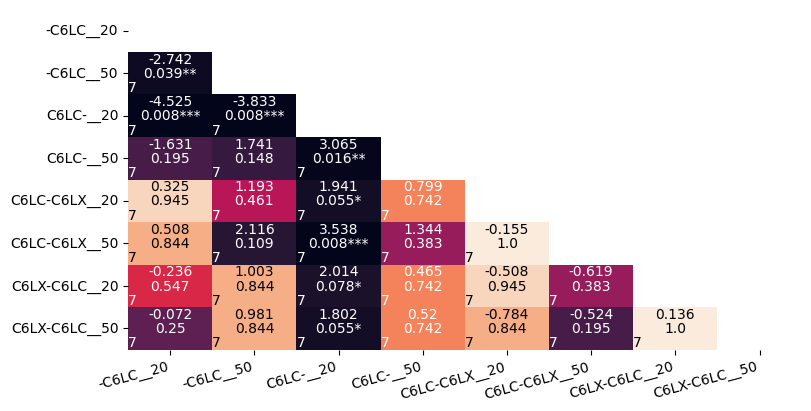

In [14]:
fig, axes = plt.subplots(1, 1, constrained_layout=True, squeeze=False, figsize=(8, 4))
ax = axes[0, 0]
sns.heatmap(pvalue, annot=False, ax=ax, cbar=False)

# Annotate
pvalue_annot_kws = {"ha": 'center', "va": 'center'}
annotate_heatmap(ax, pvalue,  np.round(pvalue, 3), 0.5, 0.5, star=True, star_arr=pvalue, **pvalue_annot_kws)
deg_annot_kws = {"ha": 'left', "va": 'bottom'}
annotate_heatmap(ax, pvalue, deg.astype(int), 0, 1, **deg_annot_kws)
statistic_annot_kws = {"ha": 'center', "va": 'top'}
annotate_heatmap(ax, pvalue, np.round(statistic, 3), 0.5, 0, **statistic_annot_kws)
ax.set_xticklabels(labels=labels, rotation=15, ha="right");
ax.set_yticklabels(labels=labels, rotation=0);


In [11]:
auc.shape

(4000, 8, 4, 2)

In [20]:
t = (auc[..., 2, 1] - auc[..., 0, 1]).nanmean(axis=0)
t.shape

stats.wilcoxon(t).pvalue

stats.ttest_1samp(t, popmean=0).statistic


(8,)

0.015625

2.1372135629649045

In [15]:
positions_inverse
charges_inverse

['-C6LC', 'C6LC-', 'C6LC-C6LX', 'C6LX-C6LC']

['20-0-80-25', '50-0-50-100']

In [14]:
positions_inverse

['-C6LC', 'C6LC-', 'C6LC-C6LX', 'C6LX-C6LC']

In [ ]:
auckkkkkk